In [436]:
import numpy as np
import importlib
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mutual_info_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import networkx as nx

import loaddata
importlib.reload(loaddata)
from loaddata import load_data

import data_vis
importlib.reload(data_vis)
from data_vis import mat2graph, plot_graph

import spectral_clustering_tools
importlib.reload(spectral_clustering_tools)
from spectral_clustering_tools import clustering, df2mat, acc_score

import graph_analysis_tools
importlib.reload(graph_analysis_tools)
from graph_analysis_tools import group_interactions, add_queen

import test_tools
importlib.reload(test_tools)
from test_tools import trainset, testset, crossvalidation

import markov_roles
importlib.reload(markov_roles)
from markov_roles import markov_chain

## DATASET 2


In [397]:
metadata, data = load_data('dataset2')

### Classification non supervisée

#### K-Means

##### Recherche des meilleurs hyper paramètres

In [398]:
datax_test, datay_test = testset(3, 1, metadata)
datax_train, datay_train = trainset(3, 1, metadata)

In [399]:
km_clf = KMeans(n_clusters=3)
km_param = {'init' : ['k-means++', 'random'], 'n_init' : np.arange(5, 20, step=5)}
grid_search_km = GridSearchCV(km_clf, km_param)
grid_search_km.fit(datax_train)

GridSearchCV(estimator=KMeans(n_clusters=3),
             param_grid={'init': ['k-means++', 'random'],
                         'n_init': array([ 5, 10, 15])})

In [400]:
print(grid_search_km.best_params_)

{'init': 'random', 'n_init': 5}


##### Classification avec validation croisée

In [401]:
km_clf = KMeans(n_clusters=3, init=grid_search_km.best_params_['init'], n_init=grid_search_km.best_params_['n_init'], random_state=1)
km_clf.fit(datax_train)
yhat_km = km_clf.predict(datax_test)

In [402]:
score = acc_score(datay_test, yhat_km)
print(score)

(0, [])


####    Spectral clustering

In [403]:
matrices, ground_truth, list_ants = df2mat(np.arange(1,6), np.arange(1,41), metadata, data)

scores_spec_clustering, preds = clustering(matrices, ground_truth, list_ants, scoring='mi')
print(np.mean(scores_spec_clustering))


0.49382183498300136


  ###  Analyse d'interactions entre les groupes

In [404]:
col = 1
day = 1

####        Avec les labels de metadata (vérité terrain)

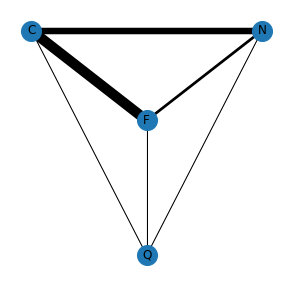

In [413]:
mat, y_true, ants = df2mat([col], [day], metadata, data, queen=True)
graph = mat2graph(mat[0], 'dataset2_col1_d1', plot=False)
graph_gr = group_interactions(graph, y_true[0], ants[0])
plot_graph(graph_gr, f'ds2_col{col}_d{day}_bygroups_queen')


#### Avec les labels prédits

In [406]:
mat, y_true, ants = df2mat([col], [day], metadata, data, queen=False)
mat_queen, pred_queen, ants_queen = add_queen(mat[0], preds[0], ants[0], metadata, col, day, data[col-1][day-1])
if len(mat_queen) != 0:
    graph_pred_queen = mat2graph(mat_queen, f'dataset2_col{col}_d{day}', plot=False)
    graph_gr_pred = group_interactions(graph_pred_queen, pred_queen, ants_queen)
    plot_graph(graph_gr_pred, f'ds2_col{col}_d{day}_bygroups_preds_queen', self_loop=True)

KeyError: 'Ant4'

#### Indices d'interactions

In [414]:
interactions_data = pd.DataFrame(columns=['int_CF', 'int_CN', 'int_CQ', 'int_NF', 'int_NQ', 'int_FQ', 'nb_int_F', 'nb_int_C', 'nb_int_N', 'moy_int_F', 'moy_int_C', 'moy_int_N'])

In [415]:
mat_adj = nx.to_numpy_matrix(graph_gr)
nb_int_total = mat_adj.sum()/2
nb_foragers = np.sum(np.where(np.array(y_true) == 0, 1, 0))
nb_cleaners = np.sum(np.where(np.array(y_true) == 1, 1, 0))
nb_nurses = np.sum(np.where(np.array(y_true) == 2, 1, 0))

int_data_col1 = [mat_adj[1,0]/nb_int_total, mat_adj[1,2]/nb_int_total, mat_adj[1,3]/nb_int_total, mat_adj[2,0]/nb_int_total,
         mat_adj[2,3]/nb_int_total, mat_adj[0,3]/nb_int_total, mat_adj[0,0], mat_adj[1,1], mat_adj[2,2],
         np.sum(mat_adj[0])/nb_foragers, np.sum(mat_adj[1])/nb_cleaners, np.sum(mat_adj[2])/nb_nurses]
interactions_data.loc[len(interactions_data.index)] = int_data_col1

C:\Users\Candice\AppData\Local\Temp/ipykernel_10704/3012550908.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(mat_adj[0])/nb_foragers, np.sum(mat_adj[1])/nb_cleaners, np.sum(mat_adj[2])/nb_nurses]


## Classification supervisée

In [329]:
period = 1

In [330]:
datax_train, datay_train = trainset(1, 1, metadata)
datax_test, datay_test = testset(1, 1, metadata)

In [358]:
supervised_classif_scores = pd.DataFrame(columns=['Classifieur', 'Accuracy train', 'Accuracy test', 'Precision train', 'Precision test', 'Recall train', 'Recall test'])

#### K-nearest neighbors

##### Recherche des meilleurs hyper paramètres

In [332]:
knn_clf = KNeighborsClassifier()
knn_param = {'n_neighbors' : np.arange(2, 15), 'weights' : ['uniform', 'distance']}
grid_search_knn = GridSearchCV(knn_clf, knn_param)
grid_search_knn.fit(datax_train, datay_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'weights': ['uniform', 'distance']})

In [333]:
print(grid_search_knn.best_params_)

{'n_neighbors': 10, 'weights': 'uniform'}


##### Classification avec validation croisée

In [334]:
knn_clf = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], weights=grid_search_knn.best_params_['weights'])
acc_test_knn, precision_test_knn, recall_test_knn = crossvalidation(knn_clf, metadata)
acc_train_knn, precision_train_knn, recall_train_knn  = crossvalidation(knn_clf, metadata, val='train')

In [359]:
supervised_classif_scores.loc[len(supervised_classif_scores.index)] = ['knn', np.mean(acc_train_knn), np.mean(acc_test_knn),
                                                                       np.mean(precision_train_knn), np.mean(precision_test_knn),
                                                                       np.mean(recall_train_knn), np.mean(recall_test_knn)]

#### Decision Tree

##### Recherche des meilleurs hyper paramètres

In [336]:
dc_clf = DecisionTreeClassifier()
dc_param = {'criterion' : ['gini', 'entropy' ], 'max_depth' : np.arange(2,20)}
grid_search_dc = GridSearchCV(dc_clf, dc_param)
grid_search_dc.fit(datax_train, datay_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])})

In [337]:
print(grid_search_dc.best_params_)

{'criterion': 'gini', 'max_depth': 3}


##### Classification avec validation croisée

In [338]:
dc_clf = DecisionTreeClassifier(criterion=grid_search_dc.best_params_['criterion'], max_depth=grid_search_dc.best_params_['max_depth'])
acc_test_dc, precision_test_dc, recall_test_dc = crossvalidation(dc_clf, metadata)
acc_train_dc, precision_train_dc, recall_train_dc  = crossvalidation(dc_clf, metadata, val='train')

In [349]:
print(dc_clf.feature_importances_)

[0.21366024 0.04101721 0.0771204  0.         0.66820215]


In [360]:
supervised_classif_scores.loc[len(supervised_classif_scores.index)] = ['decision tree', np.mean(acc_train_dc), np.mean(acc_test_dc),
                                                                       np.mean(precision_train_dc), np.mean(precision_test_dc),
                                                                       np.mean(recall_train_dc), np.mean(recall_test_dc)]

#### Naive Bayes

##### Recherche des meilleurs hyper paramètres

In [340]:
nb_clf = MultinomialNB()
nb_param = {'alpha' : [ 1e-10, 1e-8, 1e-5, 1e-2]}
grid_search_nb = GridSearchCV(nb_clf, nb_param)
grid_search_nb.fit(datax_train, datay_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.01]})

In [341]:
print(grid_search_nb.best_params_)

{'alpha': 1e-10}


##### Classification avec validation croisée

In [342]:
nb_clf = MultinomialNB(alpha=grid_search_nb.best_params_['alpha'])
acc_test_nb, precision_test_nb, recall_test_nb = crossvalidation(nb_clf, metadata)
acc_train_nb, precision_train_nb, recall_train_nb  = crossvalidation(nb_clf, metadata, val='train')

In [361]:
supervised_classif_scores.loc[len(supervised_classif_scores.index)] = ['naive bayes', np.mean(acc_train_nb), np.mean(acc_test_nb),
                                                                       np.mean(precision_train_nb), np.mean(precision_test_nb),
                                                                       np.mean(recall_train_nb), np.mean(recall_test_nb)]

### SVM

##### Recherche des meilleurs hyper paramètres

In [354]:
svm_clf = SVC(max_iter=5000, class_weight='balanced')
svm_param = { 'C' : np.arange(0.05, 1.0, step=0.05), 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' : np.arange(1,7), 'gamma' : ['scale', 'auto']}
grid_search_svm = GridSearchCV(svm_clf, svm_param)
grid_search_svm.fit(datax_train, datay_train)

C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

GridSearchCV(estimator=SVC(class_weight='balanced', max_iter=5000),
             param_grid={'C': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'degree': array([1, 2, 3, 4, 5, 6]),
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [355]:
print(grid_search_svm.best_params_)

{'C': 0.35000000000000003, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}


##### Classification avec validation croisée

In [356]:
svm_clf = SVC(max_iter=5000, class_weight='balanced', C=grid_search_svm.best_params_['C'], kernel=grid_search_svm.best_params_['kernel'], degree=grid_search_svm.best_params_['degree'], gamma=grid_search_svm.best_params_['gamma'])
acc_test_svm, precision_test_svm, recall_test_svm = crossvalidation(svm_clf, metadata)
acc_train_svm, precision_train_svm, recall_train_svm  = crossvalidation(svm_clf, metadata, val='train')

C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

In [362]:
supervised_classif_scores.loc[len(supervised_classif_scores.index)] = ['svm', np.mean(acc_train_svm), np.mean(acc_test_svm),
                                                                       np.mean(precision_train_svm), np.mean(precision_test_svm),
                                                                       np.mean(recall_train_svm), np.mean(recall_test_svm)]

### Etude des changements de rôles (Chaine de Markov)

In [417]:
roles = []
for colony in range(1,7):
    roles.append(markov_chain(metadata, colony))
for mat in roles: print(mat)


[[0.95098039 0.04901961 0.         0.        ]
 [0.38461538 0.52307692 0.09230769 0.        ]
 [0.01754386 0.22807018 0.75438596 0.        ]
 [0.         0.         0.         1.        ]]
[[0.78571429 0.21428571 0.         0.        ]
 [0.1971831  0.76056338 0.04225352 0.        ]
 [0.         0.14705882 0.85294118 0.        ]
 [0.         0.         0.         1.        ]]
[[0.9375     0.0625     0.         0.        ]
 [0.36923077 0.50769231 0.12307692 0.        ]
 [0.01986755 0.07284768 0.90728477 0.        ]
 [0.         0.         0.         1.        ]]
[[0.61290323 0.29032258 0.09677419 0.        ]
 [0.48484848 0.3030303  0.21212121 0.        ]
 [0.02272727 0.06818182 0.90909091 0.        ]
 [0.         0.         0.         1.        ]]
[[0.92207792 0.07792208 0.         0.        ]
 [0.54166667 0.41666667 0.04166667 0.        ]
 [0.0620155  0.17829457 0.75968992 0.        ]
 [0.         0.         0.         1.        ]]
[[0.90756303 0.09243697 0.         0.        ]
 [0.775 

## TODO :
   ~~- fonction taux de similarité entre deux groupes pour évaluer le modèle~~
   ~~- interaction entre groupes (agréger les graphes -> 3 ou 4 noeuds (reine ou pas))~~
    ~~- chaîne de markov avec changements de rôles (prédire le comportement d'une fourmi)~~
    - mutual information pour évaluer le clustering et les comparer -> revoir
    - faire ressortir des indices pour évaluer l'intéraction (inter et intra groupes : pourcentage du nb d'interactions avec chaque groupe, nb moyen d'interactions par fourmi d'un groupe, variance associée, stabilité des interactions au cours du temps)
    ~~- mener une campagne d'expérience pour tous les modèles~~
 ~~-  classification supervisée (avec attributs de metadata)~~
    - additionner toutes les matrices de comptage du nombre d'intéractions d'une période et comparer les résultats
    - analyser les caractéristiques qui engendrent les changements de rôles (naive bayes)
    - clusteriser avec une marche aléatoire dans les graphes (pas le temps)